<a href="https://colab.research.google.com/github/diogosanchez72/Laboratorio-Previdencia/blob/main/Trabalho_Final_diogosanchez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

FGV EPGE - Escola de Pós-Graduação em Economia
==
Laboratório Aplicado à Economia
--
Aluno: Diogo Sánchez

# Apresentação

Pergunta: Reforma da previdencia era realmente necessária?

Este é um tema muito delicado e polêmico, é comum ver debates pautados em discursos populistas que desconsideram a saúde fiscal do país e até mesmo negando que há um déficit da previdência, nesse estudo faremos uma análise exploratória dados e até mesmo umas projeções simples.

# Introdução

Para fazer o trabalho utilizarei exclusivamente os dados do Fluxo de Caixa da previdencia disponiveis no site do ipeadata  e os seguintes pacotes para trabalhar e visualizar os dados.

In [ ]:
#!pip install ipeadatapy

In [ ]:
import os
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipeadatapy as ipea
import time
from random import random 
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import clear_output,display
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

# Desenvolvimento

Como primeira etapa é importante saber quais dados que eu utilizarei, aqui abaixo está listado todos os dados do fluxo de caixa da previdencia

In [ ]:
## Listar os dados que serão utilizados e separa-los 
lista_dados = ipea.list_series('Fluxo de caixa da previdência - ')
lista_despesas = lista_dados[lista_dados['NAME'].str[:34] == 'Fluxo de caixa da previdência - de']
lista_recebimentos = lista_dados[lista_dados['NAME'].str[:35] == 'Fluxo de caixa da previdência - rec']

Agora usando a função abaixo pegarei todos os dados do fluxo de caixa da previdencia separados por tipo

In [ ]:
## Um dataframe pensado apenas nas depesas 
nome = lista_despesas['NAME'][1]
codigo = lista_despesas['CODE'][1]
despesas = ipea.timeseries(codigo)[['VALUE (R$)']]
despesas.columns = [nome[32:]]

time.sleep(5+5*random()) ## Para esquivar de um sistema de proteção do site contra web scraping 

for i in range(13):
    nome = lista_despesas['NAME'][i]
    codigo = lista_despesas['CODE'][i]
    despesas[nome[32:]] = ipea.timeseries(codigo)['VALUE (R$)']
    time.sleep(5+5*random())

despesas.head()

In [ ]:
## Um dataframe pensado apenas nos recebimentos
nome = lista_recebimentos['NAME'][0]
codigo = lista_recebimentos['CODE'][0]
recebimentos = ipea.timeseries(codigo)[['VALUE (R$)']]
recebimentos.columns = [nome[32:]]

time.sleep(5+5*random()) ## Macete pra esquivar de um sistema de proteção do site contra web scraping 

for i in range(13):
    nome = lista_despesas['NAME'][i]
    codigo = lista_despesas['CODE'][i]
    recebimentos[nome[32:]] = ipea.timeseries(codigo)['VALUE (R$)']
    time.sleep(5+5*random())

recebimentos.head()

Como a busca de dados pode ser um mistério, as vezes demora muito e as vezes é muito rápida, abaixo terei salvo todos os resultados para não ter que fazer a busca de dados toda vez que for rodar o programa.

In [ ]:
#### mesmo utilizando o time.sleep pra burlar mecanismos de defesas ainda assim o webscraping do ipeadata pode ser muito demorado
## por conta disso vou exportar os dados que tenho para csv

#despesas.to_csv('despesas_prev.csv')
#recebimentos.to_csv('recebimentos_prev.csv')

## Despesas

importante que os dados estejam completos, abaixo irei plotar os residuos (diferença da soma de todas as despesas com o despesas-total) e veremos que esse residuo é muito baixo, 0, na maior parte do tempo

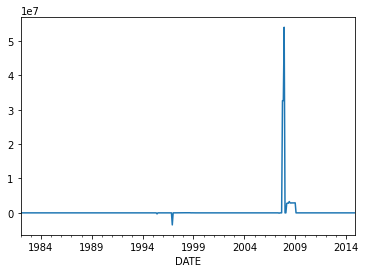

In [ ]:
## Agora vamos fazer um teste 
despesas = pd.read_csv('despesas_prev.csv').drop(columns=['despesas - INSS - Total']).replace(np.nan, 0) ##Despesas totais do INSS removida 

#despesas = despesas.drop(columns=['despesas - INSS - Total']).replace(np.nan, 0)
despesas['DATE'] = pd.to_datetime(despesas['DATE'])
despesas.set_index('DATE',inplace=True)




despesas['residuos']=despesas.sum(axis=1)
despesas['residuos'] = despesas['residuos'] - 2* despesas['despesas - total']
(despesas['residuos']).plot()  


Agora antes de fazer analise de cada componente do fluxo de caixa da previdencia, acredito que seja interessante plotar a matriz de correlação dentre as componentes, para observar se elas estão juntas correlacionadas.

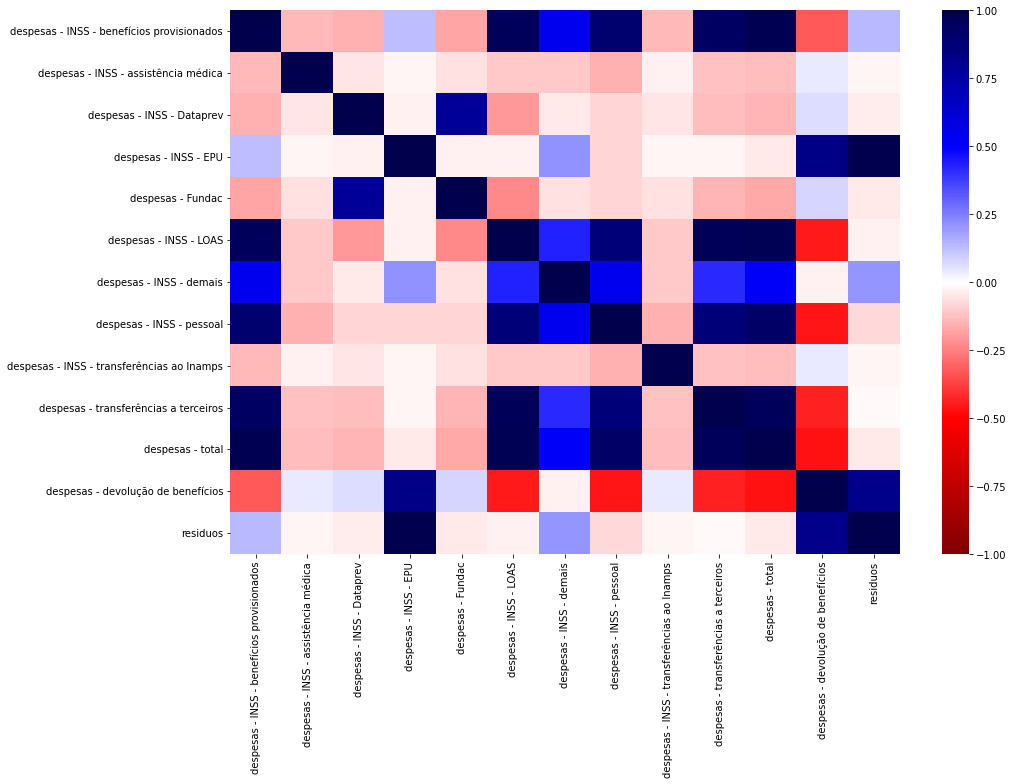

In [ ]:
## Plotagem
plt.figure(figsize=(15,10))
sns.heatmap(despesas.corr(),cmap='seismic_r',vmin=-1, vmax=1)

Percebemos aqui que fora alguns casos em que a correlação é muito alta ou muito baixa no geral a correlação entre as componenetes do fluxo de caixa tem baixa correlação entre si.

### Despesas Previdencia

Vamos analisar quais gastos que tem maior participação nas previdencia.

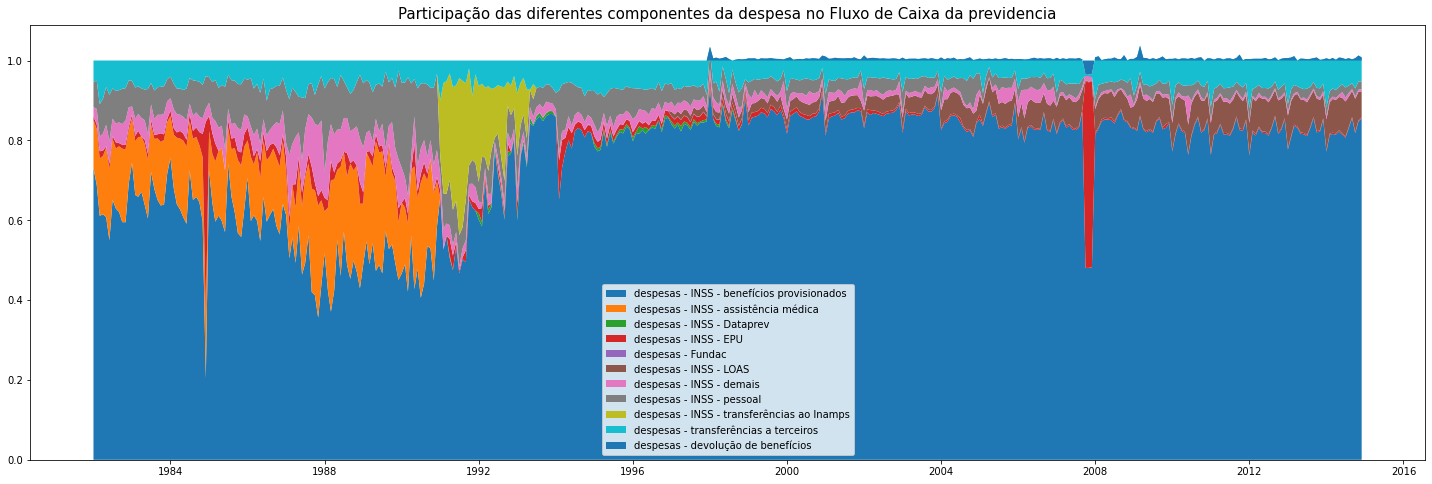

In [ ]:
## Analisar a participação
despesas_pesos = copy.deepcopy(despesas)
colunas = despesas.columns

for coluna in colunas:
    despesas_pesos[coluna] =  despesas[coluna] /( (despesas ['despesas - total'] + despesas['residuos'])) #Fração dos gastos

despesas_pesos = despesas_pesos.drop(columns=['despesas - total','residuos']) ## Vamos tirar a despesa total e o residuo né


##Figura

plt.figure(figsize=(25,8))
plt.title('Participação das diferentes componentes da despesa no Fluxo de Caixa da previdencia',fontsize=15)
_ = plt.stackplot(despesas_pesos.index,  despesas_pesos.T, labels = despesas_pesos.columns)
plt.legend(loc="lower center")

Observando esse gráfico de composição dos gastos com a matrix de correlação acima podemos dizer basicamente que o gasto mais relacionado e ao mesmo tempo o que tem maior participação nos gastos totais são os 'benefícios provisionados'.
Agora observando o primeiro gráfico abaixo você vera que há uma clara sazonalidade com periodo de um ano nos gastos da previdencia, os outros gráficos são as decomoposições dessa sazonalidade.

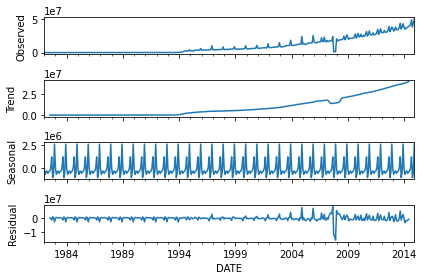

In [ ]:
analise = despesas['despesas - total']

##Desazonalizar

dec = seasonal_decompose(analise).plot()

Agora para fazer uma projeção irei desfazer a sazonalidade utilizando média movel e utilizaremos um modelo Polymonial de grau 5 para fazer a previsão.

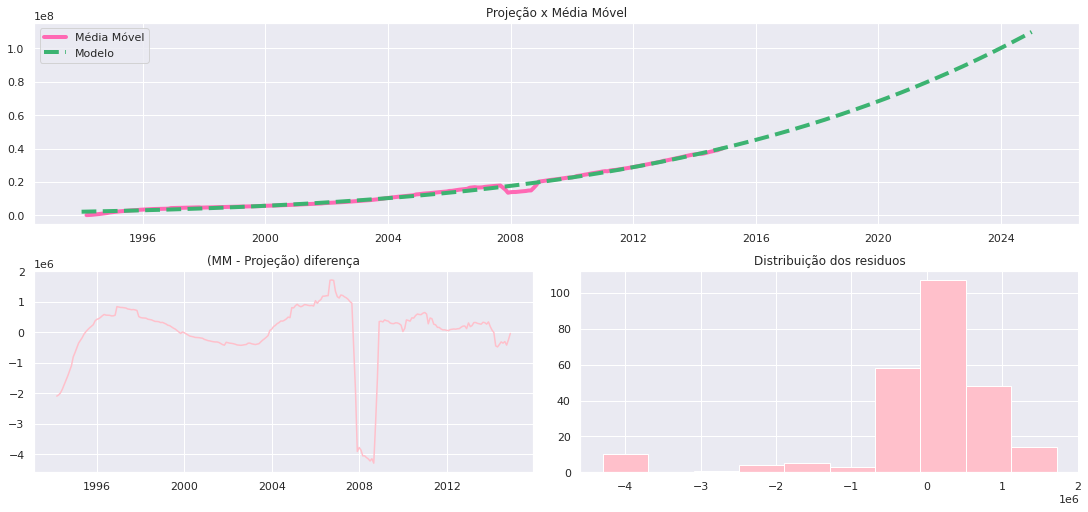

In [ ]:

## Média movel
analise_movel = analise.rolling(12).mean()
analise_movel.dropna(inplace=True)


## Modelo Polymonial
crc2=PolynomialFeatures(degree=5)
X=np.array(analise_movel[135:].index.astype(int)).reshape(-1,1)
X_p2=crc2.fit_transform(X)

lm_model = LinearRegression()
lm_model.fit(X_p2,np.array(analise_movel[135:]))

## Criar as datas
datas = pd.date_range('01-01-1994','01-01-2025',freq='d')
datas = datas[datas.day==1] ## Garantir que as datas são mensai, caso coloque freq='M' na função acima terá alguns problemas...

X_p3 = crc2.fit_transform(np.array(datas.astype(int)).reshape(-1,1))
Y_p2 = lm_model.predict(X_p3)
Y_p3 = lm_model.predict(X_p2)
residuos = analise_movel[135:]-Y_p3


modelagem = pd.DataFrame({'Data':datas,'Despesas':Y_p2})
modelagem.set_index('Data',inplace=True)


## Plotagem dos gráficos 

sns.set_theme(style='darkgrid')
figura = plt.figure(figsize=(15,7), constrained_layout=True)

gs = figura.add_gridspec(2, 2)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1,0])
ax3 = plt.subplot(gs[1,1])


ax1.plot(analise_movel[135:],lw=4,color='hotpink',label='Média Móvel')
ax1.plot(datas,Y_p2,ls='--',lw=4,color='mediumseagreen',label='Modelo')
ax1.title.set_text('Projeção x Média Móvel')
ax1.legend()

ax2.title.set_text('(MM - Projeção) diferença')
ax2.plot(analise_movel[135:].index,residuos, color='pink')

ax3.title.set_text('Distribuição dos residuos')
ax3.hist(residuos, color='pink')

clear_output(wait=True) #Deixar mais bonito
plt.show()

Agora vamos usar a mesma modelagem acima mas para observarmos as receitas.

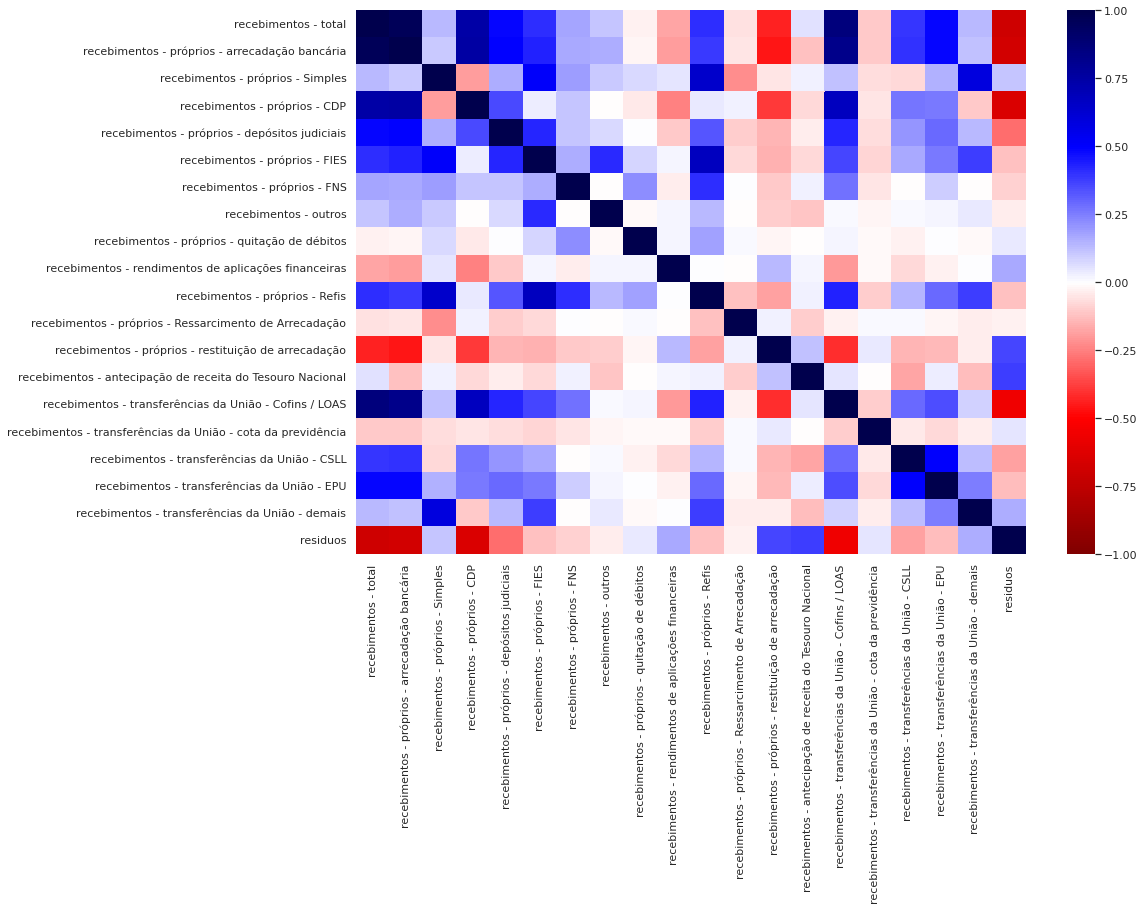

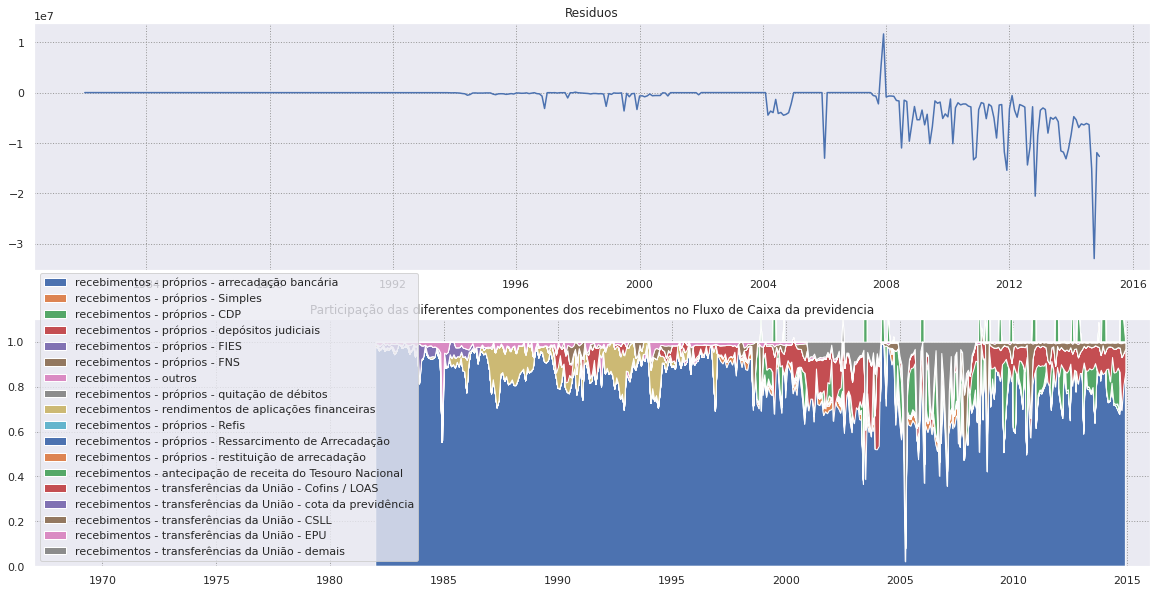

In [ ]:
#receitas = pd.read_csv('recebimentos_prev.csv').replace(np.nan, 0).drop(columns=['receita líquida do INSS', 'recebimentos - transferências da União - total','recebimentos - próprios - total'])
receitas = receitas.replace(np.nan, 0).drop(columns=['receita líquida do INSS', 'recebimentos - transferências da União - total','recebimentos - próprios - total'])
receitas['DATE'] = pd.to_datetime(receitas['DATE'])
receitas.set_index('DATE',inplace=True)

##Despesas totais do INSS removida 
receitas['residuos']=receitas.sum(axis=1)
receitas['residuos'] = receitas['residuos'] - 2* receitas['recebimentos - total']

plt.figure(figsize=(15,10))
sns.heatmap(receitas.corr(),cmap='seismic_r',vmin=-1, vmax=1)
plt.show()


receitas_pesos = copy.deepcopy(receitas)
colunas = receitas.columns

for coluna in colunas:
    receitas_pesos[coluna] =  receitas[coluna] /( (receitas ['recebimentos - total'] + receitas['residuos']))

receitas_pesos = receitas_pesos.drop(columns=['recebimentos - total','residuos'])
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
fig,ax=plt.subplots(2,1,figsize=(20,10))
ax[1].title.set_text('Participação das diferentes componentes dos recebimentos no Fluxo de Caixa da previdencia')
_ = ax[1].stackplot(receitas_pesos.index,  receitas_pesos.T, labels = receitas_pesos.columns)
ax[1].legend(loc="lower left")
ax[1].set_ylim([0, 1.1])
ax[1].set_xlim([pd.to_datetime('01-01-1967'),pd.to_datetime('01-01-2016')])
ax[0].plot(receitas['residuos'])  
ax[0].title.set_text('Residuos')


Notamos com a matriz de correlação e o gráfico de participação que, a 'arrecadação bancária' é a entrada mais parcipativa e ao mesmo tempo também é a entrada maior correlacionada com a arrecadação total. abaixo faremos um teste de desacionalidade e logo após uma regressão polinomial de grau 5.

In [ ]:
analise = receitas['recebimentos - total']
dec = seasonal_decompose(analise)
dec.plot().get_figure().set_size_inches(20,10)

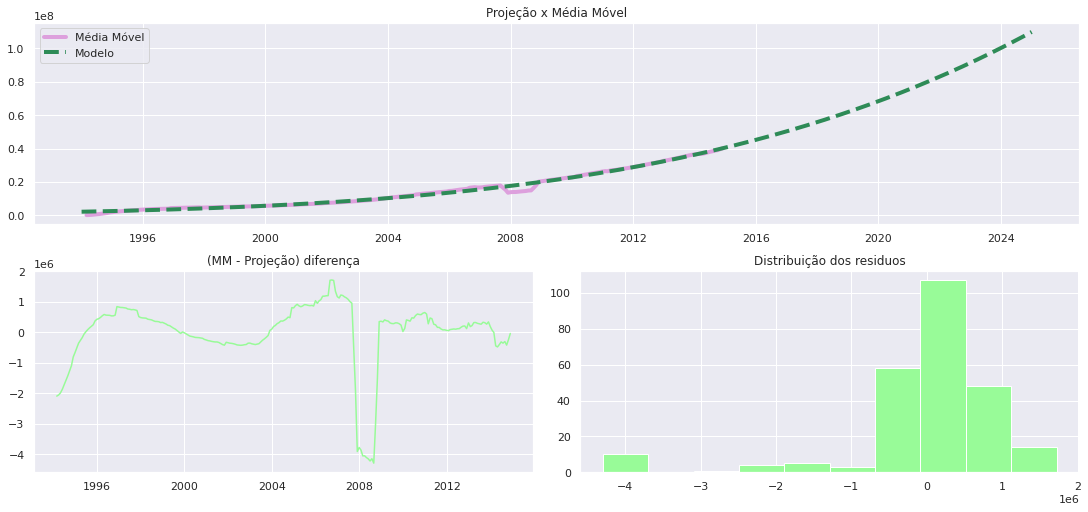

In [ ]:
analise_movel = analise.rolling(12).mean()
analise_movel.dropna(inplace=True)

crc2=PolynomialFeatures(degree=5)
X=np.array(analise_movel[135:].index.astype(int)).reshape(-1,1)
X_p2=crc2.fit_transform(X)

lm_model = LinearRegression()
lm_model.fit(X_p2,np.array(analise_movel[135:]))

datas = pd.date_range('01-01-1994','01-01-2025',freq='d')
datas = datas[datas.day==1]

X_p3 = crc2.fit_transform(np.array(datas.astype(int)).reshape(-1,1))
Y_p2 = lm_model.predict(X_p3)
Y_p3 = lm_model.predict(X_p2)
residuos = analise_movel[135:]-Y_p3


modelagem['recebimentos'] = Y_p2

sns.set_theme(style='darkgrid')
figura = plt.figure(figsize=(15,7), constrained_layout=True)

gs = figura.add_gridspec(2, 2)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1,0])
ax3 = plt.subplot(gs[1,1])


ax1.plot(analise_movel[135:],lw=4,color='plum',label='Média Móvel')
ax1.plot(datas,Y_p2,ls='--',lw=4,color='seagreen',label='Modelo')
ax1.title.set_text('Projeção x Média Móvel')
ax1.legend()

ax2.title.set_text('(MM - Projeção) diferença')
ax2.plot(analise_movel[135:].index,residuos, color='palegreen')

ax3.title.set_text('Distribuição dos residuos')
ax3.hist(residuos, color='palegreen')

clear_output(wait=True)
plt.show()

Agora que temos duas curvas de projeções uma para a receita e outra para os gastos, vamos traçar agora uma projeção para o défict da previdencia e comparalos com os dados que temos hoje.

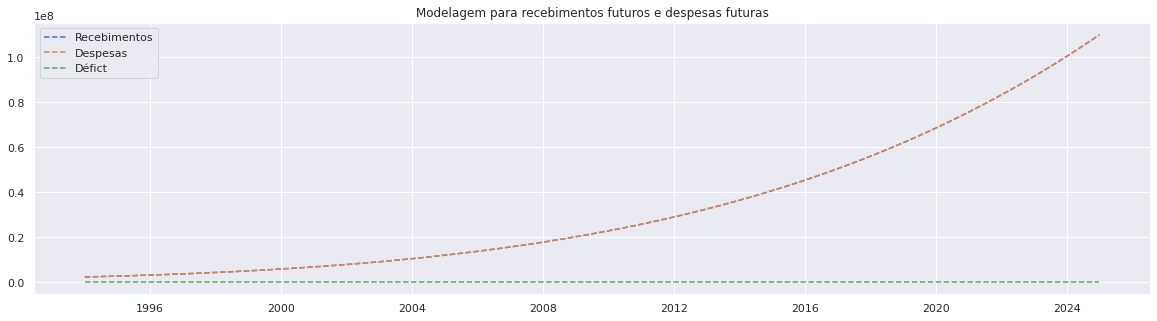

In [ ]:
modelagem['Despesas de Fato'] = despesas['despesas - total']
modelagem['Recebimentos de Fato'] = receitas['recebimentos - total']
modelagem['Défict de Fato'] = modelagem['Despesas de Fato'] - modelagem['Recebimentos de Fato']
modelagem['Défict acumulado de Fato'] = modelagem['Défict de Fato'].cumsum()
modelagem['Défict'] = - modelagem['recebimentos'] + modelagem['Despesas']


##Plotagem
plt.figure(figsize=(20,5))
plt.plot(modelagem['recebimentos'],ls='--',label='Recebimentos')
plt.plot(modelagem['Despesas'],ls='--',label='Despesas')

plt.plot(modelagem['Défict'],ls='--',label='Défict')
plt.title('Modelagem para recebimentos futuros e despesas futuras')
plt.legend()
plt.show()

Observamos que aparentemende o Défict é nulo e que ele não existe, mas na verdade esse é um assunto polêmico pois estamos observando o fluxo de caixa da previdencia e algumas dessas entradas são provenientes de outros meios além das contribuições diretas da previdencia, como por exemplos alguns dos repasses da União, esse tema gera bastante debate, pois pessoas contrárias a reforma da previdencia desconsideram alguns gastos da previdencia como por exemplo a aposentadoria de trabalhador rural e legitimam alguns repasses da União para arcar com o défict, enviesando a análise das contas públicas.
A modelagem termina por aqui pois admito que não sei quais componentes do fluxo de caixa seriam mais justos de tirar do modelo e montar a projeção, mas para não ficarmos sem nada vamos recriar o modelo desconsiderando todos os repasses da União.

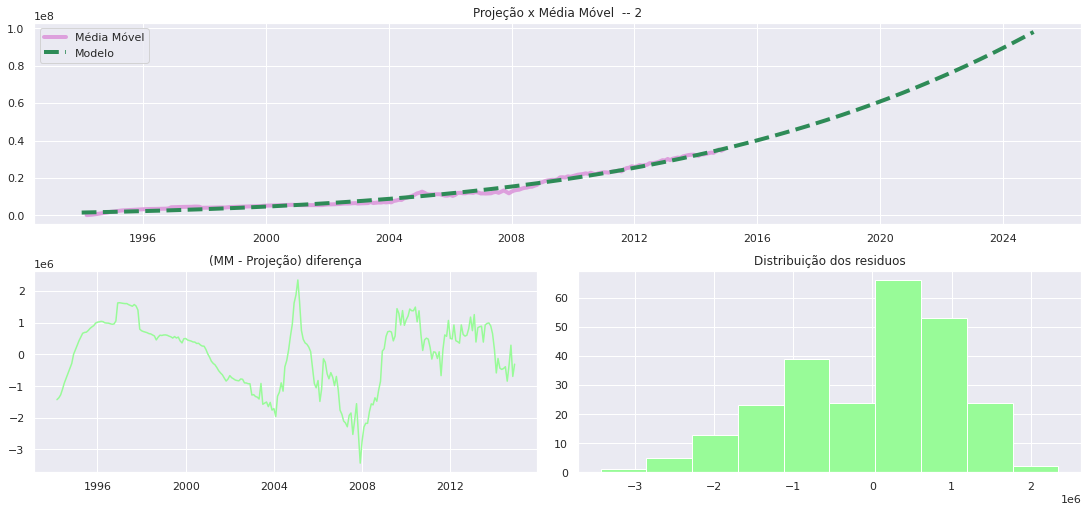

In [ ]:
analise = receitas['recebimentos - total']
for coluna in receitas.columns:
    if 'União' in coluna:
        analise = analise - receitas[coluna]

analise_movel = analise.rolling(12).mean()
analise_movel.dropna(inplace=True)

crc2=PolynomialFeatures(degree=5)
X=np.array(analise_movel[135:].index.astype(int)).reshape(-1,1)
X_p2=crc2.fit_transform(X)

lm_model = LinearRegression()
lm_model.fit(X_p2,np.array(analise_movel[135:]))

datas = pd.date_range('01-01-1994','01-01-2025',freq='d')
datas = datas[datas.day==1]

X_p3 = crc2.fit_transform(np.array(datas.astype(int)).reshape(-1,1))
Y_p2 = lm_model.predict(X_p3)
Y_p3 = lm_model.predict(X_p2)
residuos = analise_movel[135:]-Y_p3


modelagem['recebimentos 2'] = Y_p2

sns.set_theme(style='darkgrid')
figura = plt.figure(figsize=(15,7), constrained_layout=True)

gs = figura.add_gridspec(2, 2)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1,0])
ax3 = plt.subplot(gs[1,1])


ax1.plot(analise_movel[135:],lw=4,color='plum',label='Média Móvel')
ax1.plot(datas,Y_p2,ls='--',lw=4,color='seagreen',label='Modelo')
ax1.title.set_text('Projeção x Média Móvel  -- 2')
ax1.legend()

ax2.title.set_text('(MM - Projeção) diferença')
ax2.plot(analise_movel[135:].index,residuos, color='palegreen')

ax3.title.set_text('Distribuição dos residuos')
ax3.hist(residuos, color='palegreen')

clear_output(wait=True)
plt.show()


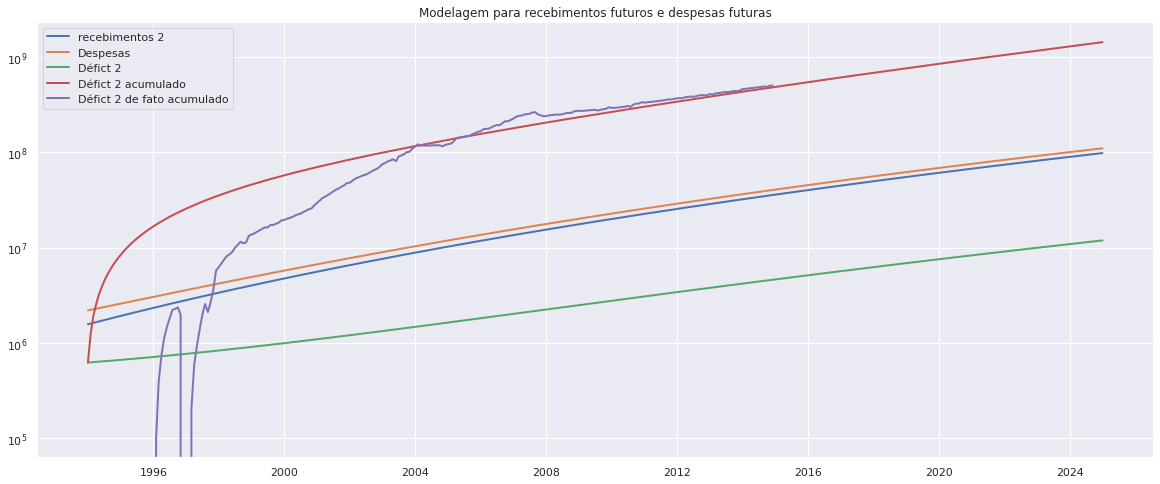

In [ ]:
modelagem['Despesas de Fato'] = despesas['despesas - total']
modelagem['Recebimentos 2 de Fato'] = analise
modelagem['Défict de Fato 2'] = modelagem['Despesas de Fato'] - modelagem['Recebimentos 2 de Fato']

modelagem['Défict 2'] = - modelagem['recebimentos 2'] + modelagem['Despesas']
modelagem['Défict 2 acumulado'] = modelagem['Défict 2'].cumsum()
modelagem['Défict 2 de fato acumulado'] = modelagem['Défict de Fato 2'].cumsum()

##Plotagem
plt.figure(figsize=(20,8))
for coluna in ['recebimentos 2','Despesas','Défict 2','Défict 2 acumulado','Défict 2 de fato acumulado']:
  plt.plot(modelagem[coluna],ls='-',lw=2,label=(coluna))
plt.title('Modelagem para recebimentos futuros e despesas futuras')
plt.legend()
plt.yscale('log')
plt.show()

Aqui desconsiderando qualquer repasse da União percebemos que o modelo se aproxima até que bem da realidade masa a curva ainda assim não parece ser muito satisfátoria. 

# Conclusão

Podesse concluir com esse trabalho que sim de fato há um défict da previdencia, mas além do estudo sobre as contas públicas ficou como aprendizado o conhecido viés de confirmaçao, enquanto buscava noticias, artigos, entre outros que explicassem a receita e os gastos da previdencia, notei que não há uma homogeniedade na maneira como essas contas são abordadas e de como as conclusões tiradas por diferentes jornais geralmente está alinhada com a ideologia do jornal, por exemplo sites e revistas mais a esquerda diziam existir até mesmo um superávit da previdencia se você desconsiderasse alguns gastos ali outros ali. Fora ter entendido melhor sobre como funciona o viés de confirmação nos meios de propagação de informação em relação a python eu consegui concluir que é uma linguagem de programação que se adequa bem para diversas tareas inclusive o estudo de dados, embora não tenha uma imensidão de pacotes para estatísticos e a facilidade de uma linguagem como R para desempenhar esse tipo de tarefa, o Python ainda sim abarca uma gama de funções que podem ajudar a fazer esse tipo de análise e em alguns casos pode até ser mais fácil que o próprio R. Além disso, consegui práticar os pacotes de regressão embora acredite que a maneira mais honesta de fazer a projeção fosse considerando a população empregada e a expectativa que esses empregados terão suas aposentadorias, fazer regressão de dados com python também foi muito interessante e bastante proveitoso, além de ser a única possivel com os dados disponíveis no ipea. 

# Referências

[Dados do Ipea]( http://www.ipeadata.gov.br/Default.aspx)

